# Lecture: Video Analysis

This notebook will let you analyze videos and images using the OpenAI Vision API, also known as the GPT-4V API.  
Details on the OpenAI Vision API can be found here:
https://platform.openai.com/docs/guides/vision

Below is the overview of this notebook.

<ol type = 1>
  <li> Generate Text with ChatGPT</li>
  <li> Generate Text Narration for a Video </li>
 </ol>

Before starting, select "Runtime->Factory reset runtime" to start with your directories and environment in the base state.

If you want to save changes to the notebook, select "File->Save a copy in Drive" from the top menu in Colab.  This will save the notebook in your Google Drive.


# Clones, Installs, and Imports

## Clone Repo

In [1]:
# Clone GitHub repository
!git clone https://github.com/zlisto/social_media_genAI

import os
os.chdir("social_media_genAI/main")


Cloning into 'social_media_genAI'...
remote: Enumerating objects: 1637, done.
remote: Counting objects: 100% (220/220), done.
remote: Compressing objects: 100% (162/162), done.
remote: Total 1637 (delta 63), reused 212 (delta 56), pack-reused 1417 (from 1)
Receiving objects: 100% (1637/1637), 159.85 MiB | 14.25 MiB/s, done.
Resolving deltas: 100% (66/66), done.
Updating files: 100% (1457/1457), done.


## Installs

In [2]:
# Install requirements
!pip install openai -q


## Imports

In [3]:
import pandas as pd
import datetime
import textwrap as tr
import os
import time
import ast
import openai

from datetime import datetime, timedelta
import base64
import requests

import matplotlib.pyplot as plt
from IPython.display import display, Image, HTML, Audio
from PIL import Image as PILImage
from moviepy.editor import ImageClip, AudioFileClip, concatenate_videoclips

import requests
from io import BytesIO
import numpy as np
import math

import cv2  # We're using OpenCV to read video, to install !pip install opencv-python

#helper functions for using ChatGPT
from scripts.chatgpt import *


pd.set_option("display.max_colwidth", None)
#this code makes the default font sizes big in plots
plt.rcParams.update({'axes.labelsize': 18,
                     'xtick.labelsize': 14,
                     'ytick.labelsize': 14})

  if event.key is 'enter':



## OpenAI API Key

You can get your OpenAI API key from https://platform.openai.com/api-keys.
Paste your key into the environment variable `"OPEN_API_KEY"`.  Then create a `client` that connects you to the OpenAI API.

In [4]:
import openai
os.environ['OPENAI_API_KEY'] = ''

OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')

client = openai.Client(api_key=OPENAI_API_KEY)

# Generate Tweets with ChatGPT


## Completions Function

The function `generate_text` takes in a user `prompt` string, a `instructions` stringm an OpenAI `client`, and the ChatGPT `model` and returns the response to the `prompt`.  We can use this function throughout the notebook to have cleaner code.  The function makes use of the OpenAI `chat.completions.create` function.

## Instructions and Prompt

We will provide `instructions` to the AI telling it its general function.  We then provide a `prompt` with the specific task we want it to to.  Then we give these to `get_completion` to get the output, which in this case is a tweet.  We can test different `model` values to see how they compare.  The model values are

1. `"gpt-4o"` - the more powerful version of ChatGPT (the o stands for Omni).  This is the default model in `get_completion`.

2. `"gpt-3.5-turbo-0125"` - the weaker and cheaper version of ChatGPT


You can find more about OpenAI's API pricing here: https://openai.com/pricing

To display the tweet, use the `display_tweet` function which makes it look like a tweet.  This function was written by ChatGPT after looking at a screenshot of a tweet.

In [5]:
instructions = '''You are going to help create content for a social
media account.  You will be asked to write clever tweets that will get
engagement.  Return only the text of the tweet.'''

topic = 'vote in the 2024 presidential election'
prompt = f'''Write a tweet about {topic}.'''

tweet = generate_text(prompt, instructions, client)
display_tweet(tweet);

## Persuasive Text Content

Lets create some persuasive content targeted for a user.  Just pick your `"topic"` you want to persuade them on and the `content` you want to perusade with (text content only).  The `description` should describe the user you are targeting.  Feel free to add anything to the `description` that you think will make the content more persuasive.

In [6]:
topic = '''vote for Trump in the 2024 presidential election'''
content = 'tweet'
description = '''A student at University of Michigan who cares about
AI.'''

instructions = f'''You will be given a description of
a fictitious person.
Convince this person to support {topic} with a {content}.
Dont directly mention the information about the target in the message.
Be more subtle as that makes the persuasion more effective. '''

prompt = f'''User description:\n{description}.'''
tweet = generate_text(prompt, instructions,client)

tweet_html = display_tweet(tweet)




## Other Text Content

For text content, you can also try

1. Tweet

2. Email

3. Buzzfeed listicle article

4. Song lyircs (you can make the song at https://suno.com/)

In [10]:
topic = '''vote for Trump in the 2024 presidential election'''
content = 'country pop song sang by a female'
description = '''A student at University of Michigan who cares about
AI.'''

instructions = f'''You will be given a description of
a fictitious person.
Convince this person to support {topic} with a {content}.
Dont directly mention the information about the target in the message.
Be more subtle as that makes the persuasion more effective. '''

prompt = f'''User description:\n{description}.'''

tweet = generate_text(prompt, instructions,client)

tweet_html = display_tweet(tweet)




# Generate Text Narration of a Video

We will take a short video from Instagram and generate a voice narration for it.  This is a bit experimental, but shows we can do video analysis using the Vision API.  More details can be found here: https://cookbook.openai.com/examples/gpt_with_vision_for_video_understanding

## Load Frames From Video

There are several videos located in the `"data/videos"` folder.  Choose one and set it to `video_path`.  

We will first convert the video into a list of images (each image corresponds to a frame in the video) called `base64Frames`.  

We also can get the number of frames in the video `nframes` and frame rate `fps` in frames per second.  We will need these when we determine how long the narration should be.

In [13]:
%%time
video_path = "data/political_ads/MAGA Sketch.mp4"
max_samples = 15

video = cv2.VideoCapture(video_path)  #open the video file
nframes = video.get(cv2.CAP_PROP_FRAME_COUNT)  #number of frames in video
fps = video.get(cv2.CAP_PROP_FPS)  #frames per second in video

print(nframes, "frames in video")
print(fps, "frames per second")

base64Frames_samples = []

frame_interval = max(1, int(nframes // max_samples))  # Calculate the interval at which to sample frames

current_frame = 0
while video.isOpened():
    success, frame = video.read()
    if not success:
        break
    if current_frame % frame_interval == 0 and len(base64Frames_samples) < max_samples:
        _, buffer = cv2.imencode(".jpg", frame)
        base64Frames_samples.append(base64.b64encode(buffer).decode("utf-8"))
    current_frame += 1

video.release()
print(len(base64Frames_samples), "frames sampled.")

718.0 frames in video
24.0 frames per second
15 frames sampled.
CPU times: user 971 ms, sys: 57.3 ms, total: 1.03 s
Wall time: 855 ms


## Look at Sampled Frames

We will give a sample of the video frames to  Vision.  We choose the `sample_period` which is the spacing between samples in frames.  This sampled list is called `base64Frames_samples`.  We will look at the sampled frames to make sure they capture the important parts of the video.

15 frames sampled.


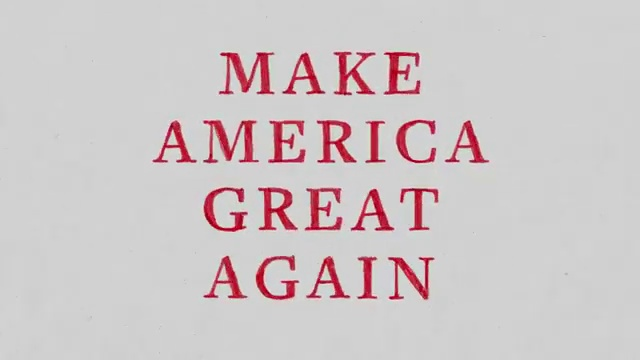

In [14]:
print(len(base64Frames_samples), "frames sampled.")

display_handle = display(None, display_id=True)

for img in base64Frames_samples:
  data = base64.b64decode(img.encode("utf-8"))
  display_handle.update(Image(data=data, height = 500))
  time.sleep(0.5)

## Create Text of Narration for Video

We give the `base64Frames_samples` and some `instructions` to Vision to generate the narration text for the video. We can choose the style and duration of the narration.  We want it to be the length of the video.  People speak about 200 words per minute.  Using this, plus the number of frames `nframes` and the video framerate `fps`, you can figure out `nwords_max`, the maximum length of the narration.

In [15]:
wps = 200/60  #words per second in normal speech
nwords_max = round(nframes/fps*wps)  #max number of words in the voice over

#formatting instructions
instructions_format =  f'''The narration should have
approximately {nwords_max} words.
 Only include the narration. '''
print(instructions_format)

The narration should have 
approximately 100 words.
 Only include the narration. 


In [17]:
#Instructions for different videos

instructions_harris = '''These are frame from an ad
for Kamala Harris 2024 Presidential campaign against Donald Trump.
Create a short narration script for this
video that would be read by actor Clint Eastwood that would convey how inspired
he is by Harris accomplishments, depsite being a republican macho man.'''

instructions_trump = '''These are frame from an ad
for Donald Trump 2024 Presidential campaign against
Kamala Harris.
Create a short narration script for this video that is
inspirational and positive.'''




In [18]:
instructions = instructions_trump
instructions += instructions_format

image_urls = [f"data:image/jpeg;base64,{base64_image}" for base64_image in base64Frames_samples]
narration = generate_image_description(image_urls, instructions,client)
print(tr.fill(narration))

In a time of challenges, we stand at a crossroads. A vision for a
brighter future beckons. With strength and determination, we rise
together, united by a common purpose. It's time to reignite the
promise of opportunity, to embrace innovation and inspire progress. We
are the architects of a hopeful tomorrow, where every voice matters
and dreams take flight. Join us as we pave the path to greatness, hand
in hand. Together, we are unstoppable. Together, we will make America
shine. Let's rally for a prosperous, united nation. A new era awaits.
The journey begins now.


## Check Length of Narration

We split `narration` by spaces `' '` and count the length of the resulting list to find out how many words in contains.

In [19]:
nwords = len(narration.split(' '))
print(f'''Video voiceover has {nwords} words
\nWe want a maximum of {nwords_max} words.''')

Video voiceover has 96 words

We want a maximum of 100 words.


## Generate Audio of Narration for Video

We can use the Speech API to convert the text `narration` into an audio file that we save to `narration_file_path`.  We can choose the voice we want.
Experiment with different voices (alloy, echo, fable, onyx, nova, and shimmer) to find one that matches your desired tone and audience. The current voices are optimized for English.

https://platform.openai.com/docs/guides/text-to-speech

In [20]:
narration_file_path = video_path.replace(".mp4", "_narration.mp3")

response = client.audio.speech.create(
  model="tts-1",
  voice="nova",
  input=narration
)

response.stream_to_file(narration_file_path)



  response.stream_to_file(narration_file_path)



## Listen to Narration Audio

In [21]:
print(tr.fill(narration))
audio = Audio(filename=narration_file_path)
display(audio)



In a time of challenges, we stand at a crossroads. A vision for a
brighter future beckons. With strength and determination, we rise
together, united by a common purpose. It's time to reignite the
promise of opportunity, to embrace innovation and inspire progress. We
are the architects of a hopeful tomorrow, where every voice matters
and dreams take flight. Join us as we pave the path to greatness, hand
in hand. Together, we are unstoppable. Together, we will make America
shine. Let's rally for a prosperous, united nation. A new era awaits.
The journey begins now.


## Cloning Voice

If you want to have some more variety in the voice narration, you can clone a voice using Eleven Labs: https://elevenlabs.io/

## Video Editing

If you want to add the audio to the video, there are many video editing softwares available online.  One you can use is this: https://online-video-cutter.com/video-editor

# Video Ad from Images

Now we will try to make a video ad from some images and text description.

## Describe the Images

First we will have the AI describe each image in detail.  We will save the description and image filename to a csv file.  This information will help the AI figure out the image sequence for the ad.

In [23]:
jotno_description = '''Jotno Foundation is dedicated to addressing the social and
health disparities perpetuating poverty in Bangladesh.

Recognizing the escalating challenges of income inequality
and climate change, Jotno aims to empower marginalized children,
youth and their families through strategic collaboration with
high-impact local initiatives.

Jotno provides sustainable strategies and financial
support to uplift and strengthen community-driven programs
by targeting gaps in education and healthcare.'''

instructions = f'''This is an image for the
Jotno Foundation: {jotno_description}.

Describe this image in detail, return only the description text
and nothing else. '''

In [26]:
image_folder = "data/jotno"
dict_list = []
for f in os.listdir(image_folder):
  if f.lower().endswith(('.png', '.jpg', '.jpeg', '.gif')):
    # Generate the full path to the image
    image_path = os.path.join(image_folder, f)
    base64_image = encode_image(image_path)
    image_url = f"data:image/jpeg;base64,{base64_image}"
    image_urls = [image_url]
    description = generate_image_description(image_urls, instructions,client)
    print(f"{f}: {description}")
    dict_list.append({'image_path':image_path,
                      'description':description,
                      })
df_img = pd.DataFrame(dict_list)
df_img.to_csv('data/jotno/image_descriptions.csv', index = False)

jotno crowd top.jpg: The image shows a large group of people sitting closely together. Viewed from above, the individuals are dressed in a variety of vibrant and colorful traditional clothing. Patterns and colors such as red, green, yellow, blue, pink, and orange dominate the scene, creating a visually striking mosaic. Many are wearing shawls and scarves, some with intricate designs, adding to the diversity of textures. The group appears to be engaged or waiting for something, with most people sitting cross-legged and facing in different directions. The overall atmosphere is vibrant and energetic, reflecting a sense of community and diversity.
jotno cooking.png: The image shows a woman and a child in a cozy, rustic kitchen. The woman, dressed in a vibrant red sari with decorative patterns, is smiling warmly while slicing vegetables over a large bowl. Her bangles add an elegant touch to her attire. The child, sitting beside her, is engrossed in a book, possibly studying from it, wearing

## Create Ad Narrations and Image Sequence

Now we will have the AI give us a script for the ad from the image descriptions.  The script has an image and narration for each scene.  We will save the script to a dataframe `df_script`.

In [27]:
df_img = pd.read_csv('data/jotno/image_descriptions.csv')


In [28]:
image_info = df_img[['image_path','description']].to_string()
image_info

'                             image_path                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      description\n0        data/jotno/jotno crowd top.jpg           The image shows a large group of people sitting closely together. Viewed from above, the individuals are dressed in a variety of vibrant and colorful traditional clothing. Patterns and colors such as red, green, yellow, blue, pink, and orange dominate the scene, crea

In [29]:
instructions = f'''You will be given the filepath and
description of images I want to use to make
a fundraising ad for the Jotno Foundation. The Foundation
description is: {jotno_description}.
'''


instructions +='''Look at the image descriptions and return
to me the script for a 30 second ad for the Foundation.
Return your answer
in JSON format with structure
[{'scene':scene number,
  'image_path':image_path,
  'narration':narration text}]
 '''
prompt = f'''Image path and descriptions: {image_info} '''

script = generate_text(prompt, instructions, client)


In [30]:
s = script.replace('`',"").replace('json',"").replace("\n","")
df_script = pd.DataFrame(eval(s))
df_script

,scene,image_path,narration
0,1,data/jotno/jotno logo.png,"In Bangladesh, bright futures begin with the seeds of hope and care. Welcome to Jotno Foundation."
1,2,data/jotno/jotno crowd top.jpg,"Here, vibrant communities gather, bound by diversity and unity. This is where the journey starts."
2,3,data/jotno/jotno cooking.png,"Empowering families through education and tradition, fostering growth one generation at a time."
3,4,data/jotno/jotno nurse computer.jpeg,"With strategic collaboration, we bridge gaps in healthcare and education, nurturing potential and prosperity."
4,5,data/jotno/jotno eyes.jpeg,"Compassionate healthcare that sees beyond barriers, reaching the most vulnerable."
5,6,data/jotno/jotno teaching.jpeg,"Our programs empower individuals to lead change within their communities, a legacy of impact."
6,7,data/jotno/jotno mela.jpeg,"In harmony with tradition and nature, we celebrate progress and resilience together."
7,8,data/jotno/jotno kids.jpeg,"Lifting the dreams of children and youth, ensuring bright futures take root for generations to come."
8,9,data/jotno/jotno Yunus.jpeg,"Join hands with Jotno Foundation. Together, we create sustainable change and brighter tomorrows."


## Create Audio Narrations for Ad

Now we can make the audio narration for each scene in the script and save the mp3 files.

In [32]:
audio_paths = []
for index, row in df_script.iterrows():
  audio_fname = f"scene_{row.scene}.mp3"
  print(audio_fname)
  audio_path = os.path.join(image_folder, audio_fname)
  narration = row.narration

  response = client.audio.speech.create(
    model="tts-1",
    voice="nova",
    input=narration
  )

  response.stream_to_file(audio_path)
  audio_paths.append(audio_path)
df_script['audio_path'] = audio_paths

scene_1.mp3


  response.stream_to_file(audio_path)



scene_2.mp3
scene_3.mp3
scene_4.mp3
scene_5.mp3
scene_6.mp3
scene_7.mp3
scene_8.mp3
scene_9.mp3


## Create Final Ad Video

Finally, we combine the images and audio for each scene together to make the final ad.  The ad will be saved to the location specified by `ad_path`.

In [35]:
ad_path = "data/jotno/jotno_ad.mp4"


# Define the target width and height for the video
target_width, target_height = 640, 360  # Example for 360p resolution

# List to store individual clips
clips = []

for index, row in df_script.iterrows():
    # Load the image and audio for each scene
    image_path = row['image_path']
    audio_path = row['audio_path']

    # Create an ImageClip from the image
    image_clip = ImageClip(image_path)

    # Resize the image to cover the screen completely (fill mode)
    image_clip = image_clip.resize(height=target_height)  # Resize to match the target height

    # If the image width is smaller than the target width, resize by width
    if image_clip.w < target_width:
        image_clip = image_clip.resize(width=target_width)


    # Load the audio file
    audio_clip = AudioFileClip(audio_path)

    # Set the duration of the image clip to match the audio duration
    image_clip = image_clip.set_duration(audio_clip.duration)

    # Set the audio of the image clip
    image_clip = image_clip.set_audio(audio_clip)

    # Add the clip to the list
    clips.append(image_clip)

# Concatenate all the clips into a single video
final_video = concatenate_videoclips(clips, method="compose")

# Write the final video to a file
final_video.write_videofile(ad_path,
                            codec="libx264",
                            fps=24,
                            preset="fast")


Moviepy - Building video data/jotno/jotno_ad.mp4.
MoviePy - Writing audio in jotno_adTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video data/jotno/jotno_ad.mp4



Moviepy - Done !
Moviepy - video ready data/jotno/jotno_ad.mp4


## Watch Ad Video

In [36]:
from IPython.display import Video
ad_path = "data/jotno/jotno_ad.mp4"

# Display the video in the notebook
Video(ad_path, embed=True, width=640, height=360)
